# Project: PlotGEN

**Concept**

Why would we hard-code a plotline structure? My idea is to have the computer look at a text, discern important plot information from it, and construct its own story from that.

**Outline**
1. Compile texts from sources
    - Gutenberg
    - webscraper
2. Analyze the texts
    - Characters
        - build frequency table of characters appearances
        - account for first / second person narration
        - the most frequently mentioned character is most likely the main character
    - Setting
        - use Wordnet to find locations
        - find descriptors of locations to apply as modifiers
3. Build plot structure for each text
    - Summarize each text?
    - Distill each sentence down to basic concepts
        - Example: "Michael walked along the sandy, desolate beach" -> "Michael walked beach" -> `[Michael, ACTION, SETTING]` 
4. Train unsupervised learning model on plot structures
    - Clustering in n-dimensional space
5. Generate plot structure using structures
    - Group it with closest cluster
    - Change aspect
    - Repeat until firmly within the cluster
6. Profit?

In [236]:
from gensim.summarization.summarizer import summarize
from nltk.corpus import gutenberg as gb
from nltk import tokenize, pos_tag
from nltk import wordnet as wn
import spacy
import en_core_web_sm
import gensim 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
import numpy as np
import random

In [143]:
# comment this line out if cloning from Github; the shrunkengooglevectors.bin file was too large to push
wv_from_bin = KeyedVectors.load_word2vec_format("data\\shrunkengooglevectors.bin", binary=True)

---
### Step 1
- Get the text(s)

In [104]:
# Read in Call of Cthulhu
f = open('data\\call_of_cthulhu', 'r', encoding="utf8")
cthulhu_str = f.read()
f.close()

---
### Step 2
- Analyze the text(s)
- Get character list, main character, locations, etc
- Try to get general plotline structure

In [133]:
# Get characters from text
def get_chars(input_text_str):
    # some of this code is taken from the spaCy tutorial
    # Load English tokenizer, tagger, parser, NER and word vectors
    nlp = en_core_web_sm.load()
    text = (input_text_str)
    doc = nlp(text)
    
    entity_just_persons = set([entity.text for entity in doc.ents if entity.label_ == "PERSON"])
    entity_good = [entity.text for entity in doc.ents if entity.label_ == "PERSON" or 
                   (entity.label_ == "GPE" and entity.text in entity_just_persons)]
    char_dict = {}
    for ent_text in entity_good:
        if ent_text in char_dict:
            char_dict[ent_text] += 1
        else:
            char_dict[ent_text] = 1
    char_list = [(key, char_dict[key]) for key in list(char_dict.keys()) if char_dict[key] > 1]
    char_list.sort(key=lambda x: x[1], reverse=True)
    return char_list

In [156]:
# Abandoned this idea for now, keeping it here for record of what my process has been

# Build graph of sentence to sentence flow
def build_sentence_graph(input_text_str, char_list):
    char_dict = {}
    for char in char_list:
        char_dict[char[0]] = char[1]
    
    paragraphs = input_text_str.split("\n")
    
    char_sents = []
    return char_sents

In [206]:
# Get structure of plot via sentiment analysis
def get_plot_struct(input_text_str):
    paragraphs = input_text_str.split("\n")
    tokenized_paras = []
    
    for paragraph in paragraphs:
        sentences = []
        if len(paragraph) < 2:
            continue
        token_para = tokenize.sent_tokenize(paragraph)
        for sentence in token_para:
            if len(sentence) < 5:
                continue
            token_sentence = tokenize.word_tokenize(sentence)
            sentences.append(token_sentence)
        if len(sentences) < 2:
            continue
        tokenized_paras.append(sentences)
    
    posf = open("data\\opinion-lexicon-English\\positive-words.txt", 'r')
    negf = open("data\\opinion-lexicon-English\\negative-words.txt", 'r')
    
    pos_words = posf.read()
    neg_words = negf.read()
    
    posf.close()
    negf.close()
    
    pos_set = set(pos_words.split("\n"))
    neg_set = set(neg_words.split("\n"))
    
    storyline = [[],[]]
    
    for i in range(len(tokenized_paras)):
        para = tokenized_paras[i]
        total_pos = 0; total_pos_sents = 0
        total_neg = 0; total_neg_sents = 0
        total_sents = 0
        
        valid_para = False
        
        for sent in para:
            valid_sent = False
            points_pos = 0
            points_neg = 0
            
            for word in sent:
                if word in pos_set:
                    points_pos += 1
                    valid_sent = True
                    continue
                elif word in neg_set:
                    points_neg += 1
                    valid_sent = True
                    continue
                """
                else:
                    similar_list = wv_from_bin.most_similar(word) if word in wv_from_bin else []
                    if len(similar_list) > 0:
                        for sim_word in similar_list:
                            if sim_word in pos_set:
                                points_pos += 1
                                valid_sent = True
                                continue
                            elif sim_word in neg_set:
                                points_neg += 1
                                valid_sent = True
                                continue
                """
            
            if not valid_sent:
                continue
            
            total_sents += 1
            
            if points_pos > points_neg:
                total_pos += (points_pos)
                total_pos_sents += 1
            elif points_neg > points_pos:
                total_neg += (points_neg)
                total_neg_sents += 1
            
            if not valid_para and valid_sent:
                valid_para = True
        
        if not valid_para:
            continue
        
        storyline[0].append(i)
        
        if total_pos > total_neg:
            storyline[1].append(total_pos)
        elif total_neg > total_pos:
            storyline[1].append(-total_neg)
        else:
            storyline[1].append(0.0)
    
    for i in range(len(storyline[1])):
        if storyline[1][i] == 0.0:
            if i == 0 or i == len(storyline[1])-1:
                continue
            storyline[1][i] = (storyline[1][i-1] + storyline[1][i+1]) / 2
    
    return storyline

---
### Testing

In [137]:
# CALL OF CTHULHU

# test step 2
cthulhu_chars = get_chars(cthulhu_str)
print(cthulhu_chars)

[('Johansen', 18), ('Angell', 14), ('Legrasse', 12), ('Wilcox', 11), ('Castro', 9), ('Alert', 9), ('Cthulhu', 8), ('Emma', 8), ('Dunedin', 6), ('Professor Webb', 3), ('Donovan', 3), ('Webb', 2), ('W. Longitude', 2), ('Gustaf Johansen', 2), ('Collins', 2), ('Sydney', 2), ('Egeberg', 2)]


In [157]:
cthulhu_sentence_graph = build_sentence_graph(cthulhu_str, cthulhu_chars)
print(cthulhu_sentence_graph)

[]


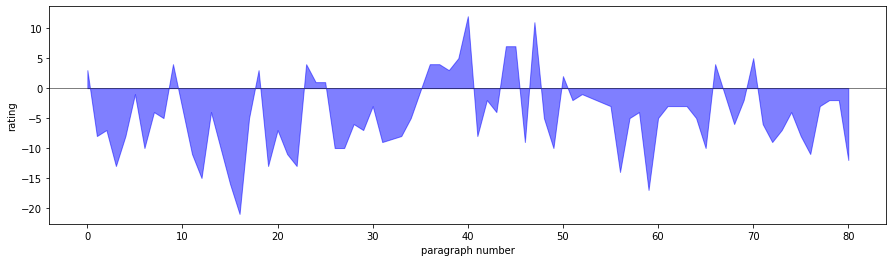

In [279]:
cthulhu_storyline = get_plot_struct(cthulhu_str)
plt.figure(figsize=(15,4))
#plt.plot(cthulhu_storyline[0], cthulhu_storyline[1], 'b-')
plt.fill_between(cthulhu_storyline[0], 0, cthulhu_storyline[1], color='b', alpha=0.5)
plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

In [227]:
# EMMA
emma_str = gb.raw('austen-emma.txt')
emma_storyline = get_plot_struct(emma_str)

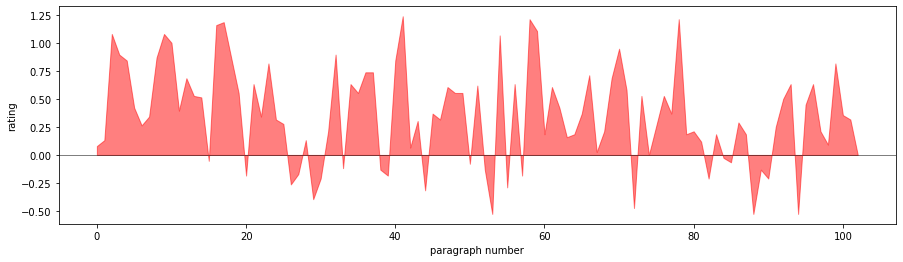

In [278]:
storyline_hundredth = [[],[]]

n = round(len(emma_storyline[1])/100)

for i in range(0, len(emma_storyline[1]), n): 
    storyline_hundredth[0].append(i / n)
    if i+n < len(emma_storyline[1]):
        average_val = sum(emma_storyline[1][i:i + n])/n
        storyline_hundredth[1].append(average_val) 
    else:
        average_val = sum(emma_storyline[1][i:])/len(emma_storyline[1][i:])
        storyline_hundredth[1].append(average_val)                                      

plt.figure(figsize=(15,4))
#plt.plot(storyline_hundredth[0], storyline_hundredth[1], 'r-')
plt.fill_between(storyline_hundredth[0], 0, storyline_hundredth[1], color='r', alpha=0.5)
plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

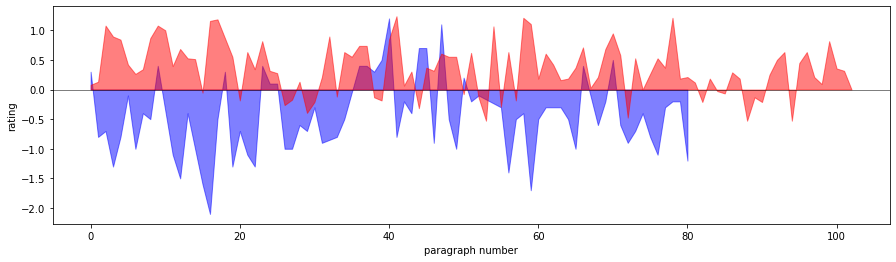

In [283]:
plt.figure(figsize=(15,4))
#plt.plot(storyline_hundredth[0], storyline_hundredth[1], 'r-')
#plt.plot(cthulhu_storyline[0], [pl/10 for pl in cthulhu_storyline[1]], 'b-')
plt.fill_between(cthulhu_storyline[0], 0, [pl/10 for pl in cthulhu_storyline[1]], color='b', alpha=0.5)
plt.fill_between(storyline_hundredth[0], 0, storyline_hundredth[1], color='r', alpha=0.5)
plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

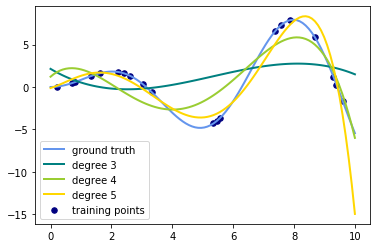

In [243]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()